In [46]:
import random

import numpy as np


# player rolls die, let x be the die number
# house rolls x fair dice
# player wins of the avg of the house's dice rolls is less than x

def play():
    x = random.choice([1,2,3,4,5,6])
    house_rolls = [random.choice([1,2,3,4,5,6]) for i in range(x)]
    house_avg = sum(house_rolls) / len(house_rolls)
    
    return 1 if house_avg < x else 0 # 1 if player wins

num_simulations = 5000
simulations = np.zeros(num_simulations)

for i in range(num_simulations):
    simulations[i] = play()
    
print(simulations.mean())
"""

"""


0.495026


In [ ]:
"""
"""
import numpy as np
import math
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

model = BayesianNetwork([('X', 'Winner'),
                         ('HouseAvg', 'Winner'),
                         ('X', 'HouseAvg')
                         ])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sensitivity, specificity]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


Estimated sensitivity: 0.506
Estimated specificity: 0.971
Probability of positive test result: 0.030


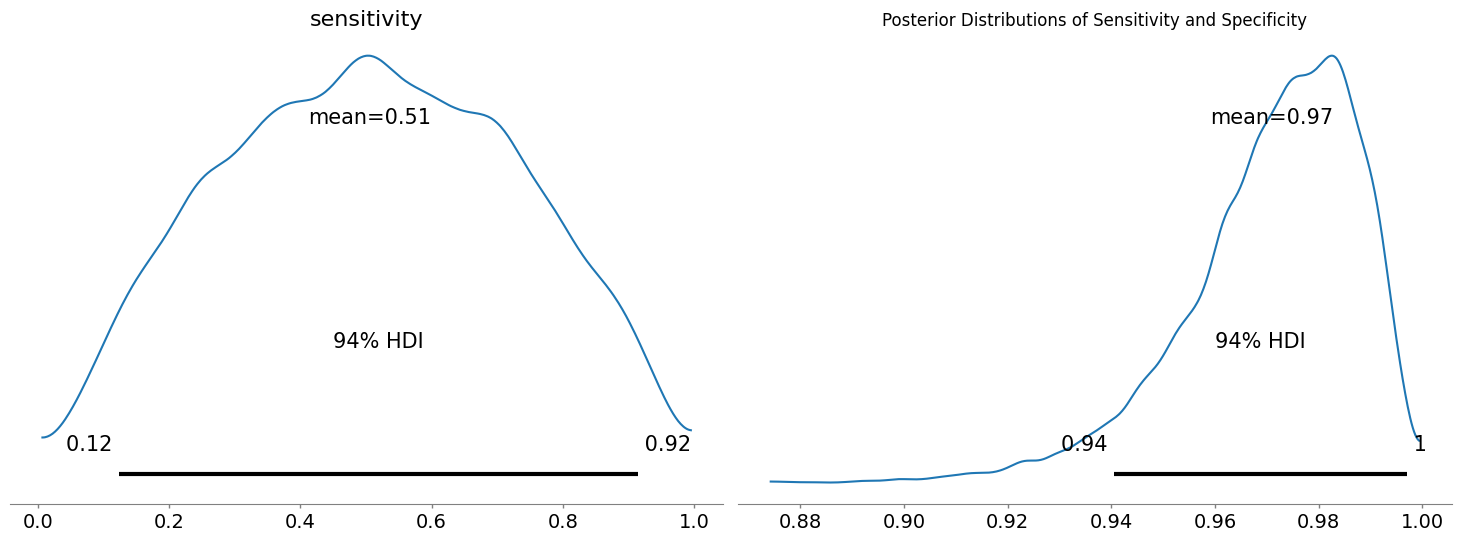

In [48]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

p_condition = 0.001
true_sensitivity = 0.95
true_specificity = 0.98
n_samples = 100

true_condition = np.random.binomial(1, 0.001, n_samples)


test_results = np.zeros(n_samples)
for i in range(n_samples):
    if true_condition[i]:
        # Person has condition - use sensitivity
        test_results[i] = np.random.binomial(1, true_sensitivity)
    else:
        # Person doesn't have condition - use specificity
        test_results[i] = 1 - np.random.binomial(1, true_specificity)

# Create the model
with pm.Model() as my_model:
    # Prior for mu - chosen based on typical bank waiting times
    sensitivity = pm.Beta(name="sensitivity", alpha=2, beta=2)
    specificity = pm.Beta(name="specificity", alpha=2, beta=2)
    
    # Likelihood
    y = pm.Bernoulli('likelihood', p=(sensitivity * true_condition + (1-specificity) * (1-true_condition)), observed=test_results)

    # Sample
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
# Visualize results
def plot_results(trace):
    az.plot_posterior(trace, var_names=['sensitivity', 'specificity'])
    plt.title('Posterior Distributions of Sensitivity and Specificity')
    plt.tight_layout()

plot_results(trace)

# Calculate probability of positive test result
post_sens = trace.posterior['sensitivity'].mean(dim=['chain', 'draw']).values
post_spec = trace.posterior['specificity'].mean(dim=['chain', 'draw']).values
p_positive = p_condition * post_sens + (1 - p_condition) * (1 - post_spec)

print(f"Estimated sensitivity: {post_sens:.3f}")
print(f"Estimated specificity: {post_spec:.3f}")
print(f"Probability of positive test result: {p_positive:.3f}")

In [5]:
import pymc as pm
import numpy as np

data = [10,20]

with pm.Model() as queue_model:
    # Prior distributions
    mu = pm.Gamma('mu', alpha=2, beta=0.5)  # Prior for mean waiting time
    sigma = pm.HalfNormal('sigma', sigma=10)  # Prior for standard deviation
    
    # Likelihood
    wait_times = pm.LogNormal('wait_times', mu=mu, sigma=sigma, observed=data)